In [ ]:
# Authors: 
## AKASH SAINI: CS21M003
## RETURAJ BURNWAL: CS21D406


from math import floor
import numpy as np

def row_col_to_seq(row_col, num_cols):  #Converts state number to row_column format
    return row_col[:,0] * num_cols + row_col[:,1]

def seq_to_col_row(seq, num_cols): #Converts row_column format to state number
    r = floor(seq / num_cols)
    c = seq - r * num_cols
    return np.array([[r, c]])

class GridWorld :
    """
    Creates a gridworld object to pass to an RL algorithm.
    Parameters
    ----------
    num_rows : int
        The number of rows in the gridworld.
    num_cols : int
        The number of cols in the gridworld.
    start_state : numpy array of shape (1, 2), np.array([[row, col]])
        The start state of the gridworld (can only be one start state)
    goal_states : numpy arrany of shape (n, 2)
        The goal states for the gridworld where n is the number of goal
        states.
    """
    def __init__(self, num_rows, num_cols, start_state, goal_states, wind = False):
        self.num_rows = num_rows
        self.num_cols = num_cols
        self.start_state = start_state
        self.goal_states = goal_states
        self.obs_states = None
        self.bad_states = None
        self.num_bad_states = 0
        self.p_good_trans = None
        self.bias = None
        self.r_step = None
        self.r_goal = None
        self.r_dead = None
        self.gamma = 1 # default is no discounting
        self.wind = wind

    def add_obstructions(self, obstructed_states=None, bad_states=None, restart_states=None):

        self.obs_states = obstructed_states
        self.bad_states = bad_states
        if bad_states is not None:
            self.num_bad_states = bad_states.shape[0]
        else:
            self.num_bad_states = 0
        self.restart_states = restart_states
        if restart_states is not None:
            self.num_restart_states = restart_states.shape[0]
        else:
            self.num_restart_states = 0

    def add_transition_probability(self, p_good_transition, bias):

        self.p_good_trans = p_good_transition
        self.bias = bias

    def add_rewards(self, step_reward, goal_reward, bad_state_reward=None, restart_state_reward = None):

        self.r_step = step_reward
        self.r_goal = goal_reward
        self.r_bad = bad_state_reward
        self.r_restart = restart_state_reward


    def create_gridworld(self):

        self.num_actions = 4
        self.num_states = self.num_cols * self.num_rows# +1
        self.start_state_seq = row_col_to_seq(self.start_state, self.num_cols)
        self.goal_states_seq = row_col_to_seq(self.goal_states, self.num_cols)

        # rewards structure
        self.R = self.r_step * np.ones((self.num_states, 1))
        #self.R[self.num_states-1] = 0
        self.R[self.goal_states_seq] = self.r_goal
        
        for i in range(self.num_bad_states):
            if self.r_bad is None:
                raise Exception("Bad state specified but no reward is given")
            bad_state = row_col_to_seq(self.bad_states[i,:].reshape(1,-1), self.num_cols)
            #print("bad states", bad_state)
            self.R[bad_state, :] = self.r_bad
        for i in range(self.num_restart_states):
            if self.r_restart is None:
                raise Exception("Restart state specified but no reward is given")
            restart_state = row_col_to_seq(self.restart_states[i,:].reshape(1,-1), self.num_cols)
            #print("restart_state", restart_state)
            self.R[restart_state, :] = self.r_restart

        # probability model
        if self.p_good_trans == None:
            raise Exception("Must assign probability and bias terms via the add_transition_probability method.")

        self.P = np.zeros((self.num_states,self.num_states,self.num_actions))
        for action in range(self.num_actions):
            for state in range(self.num_states):


                # check if the state is the goal state or an obstructed state - transition to end
                row_col = seq_to_col_row(state, self.num_cols)
                if self.obs_states is not None:
                    end_states = np.vstack((self.obs_states, self.goal_states))
                else:
                    end_states = self.goal_states

                if any(np.sum(np.abs(end_states-row_col), 1) == 0):
                    self.P[state, state, action] = 1

                # else consider stochastic effects of action
                else:
                    for dir in range(-1,2,1):
                        
                        direction = self._get_direction(action, dir)
                        next_state = self._get_state(state, direction)
                        if dir == 0:
                            prob = self.p_good_trans
                        elif dir == -1:
                            prob = (1 - self.p_good_trans)*(self.bias)
                        elif dir == 1:
                            prob = (1 - self.p_good_trans)*(1-self.bias)

                        self.P[state, next_state, action] += prob

                # make restart states transition back to the start state with
                # probability 1
                if self.restart_states is not None:
                    if any(np.sum(np.abs(self.restart_states-row_col),1)==0):
                        next_state = row_col_to_seq(self.start_state, self.num_cols)
                        self.P[state,:,:] = 0
                        self.P[state,next_state,:] = 1
        return self

    def _get_direction(self, action, direction):

        left = [2,3,1,0]
        right = [3,2,0,1]
        if direction == 0:
            new_direction = action
        elif direction == -1:
            new_direction = left[action]
        elif direction == 1:
            new_direction = right[action]
        else:
            raise Exception("getDir received an unspecified case")
        return new_direction

    def _get_state(self, state, direction):

        row_change = [-1,1,0,0]
        col_change = [0,0,-1,1]
        row_col = seq_to_col_row(state, self.num_cols)
        row_col[0,0] += row_change[direction]
        row_col[0,1] += col_change[direction]

        # check for invalid states
        if self.obs_states is not None:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1) or
                np.any(np.sum(abs(self.obs_states - row_col), 1)==0)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]
        else:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]

        return next_state

    def reset(self):
      return int(self.start_state_seq)
      
    def step(self, state, action):
        p, r = 0, np.random.random()
        for next_state in range(self.num_states):
            
            p += self.P[state, next_state, action]
            
            if r <= p:
                break

        if(self.wind and np.random.random() < 0.4):

          arr = self.P[next_state, :, 3]
          next_next = np.where(arr == np.amax(arr))
          next_next = next_next[0][0]
          return next_next, self.R[next_next]
        else:
          return next_state, self.R[next_state]



In [ ]:
# Please see get_environment() method

# # specify world parameters
# num_cols = 10
# num_rows = 10
# obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
#                          [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
#                          [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
#                          [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])
# bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])
# restart_states = np.array([[3,7],[8,2]])
# start_state = np.array([[3,6]])
# goal_states = np.array([[0,9],[2,2],[8,7]])

# # create model
# gw = GridWorld(num_rows=num_rows,
#                num_cols=num_cols,
#                start_state=start_state,
#                goal_states=goal_states, wind = False)
# gw.add_obstructions(obstructed_states=obstructions,
#                     bad_states=bad_states,
#                     restart_states=restart_states)
# gw.add_rewards(step_reward=-1,
#                goal_reward=10,
#                bad_state_reward=-6,
#                restart_state_reward=-100)
# gw.add_transition_probability(p_good_transition=0.7,
#                               bias=0.5)
# env = gw.create_gridworld()

In [ ]:
# print("Number of actions", env.num_actions) #0 -> UP, 1-> DOWN, 2 -> LEFT, 3-> RIGHT
# print("Number of states", env.num_states)
# print("start state", env.start_state_seq)
# print("goal state(s)", env.goal_states_seq)

### Our Code

##### Setup

In [ ]:
# About WANDB: https://wandb.ai/site

!pip install wandb

In [ ]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

In [ ]:
np.random.seed(3)

##### Model Code

In [ ]:
def get_environment(start_state, wind, p_good_transition):
  """
  start_state: eg: np.array([[3, 6]])
  wind: boolean
  p_good_transition: float between (0, 1)
  """
  # fixed world parameters
  num_cols = 10
  num_rows = 10
  obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                           [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                           [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                           [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])
  bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])
  restart_states = np.array([[3,7],[8,2]])
  goal_states = np.array([[0,9],[2,2],[8,7]])

  step_reward = -1
  goal_reward = 10,
  bad_state_reward = -6
  restart_state_reward = -100

  bias=0.5

  # create grid world
  gw = GridWorld(num_rows=num_rows,
                 num_cols=num_cols,
                 start_state=start_state,
                 goal_states=goal_states, wind=wind)
  gw.add_obstructions(obstructed_states=obstructions,
                      bad_states=bad_states,
                      restart_states=restart_states)
  gw.add_rewards(step_reward=step_reward,
                 goal_reward=goal_reward,
                 bad_state_reward=bad_state_reward,
                 restart_state_reward=restart_state_reward)
  gw.add_transition_probability(p_good_transition=p_good_transition,
                                bias=bias)
  return gw.create_gridworld()

In [ ]:
# Code for Exploration Strategy

class ExplorationStrategy(object):
  def get_action(self, Q):
    raise NotImplementedError


class EpsilonGreedy(ExplorationStrategy):
  def __init__(self, ep):
    self.ep = ep

  def get_action(self, Q, state):
    """
    Q: num_state(|S|) x num_actions(|A|)
    state: state_id
    """
    num_actions = Q.shape[1]
    if np.random.rand() < self.ep:
      action = np.random.randint(num_actions)
    else:
      action = np.argmax(Q[state, :])
    return action


class Softmax(ExplorationStrategy):
  def __init__(self, beta):
    self.beta = beta

  def get_action(self, Q, state):
    """
    Q: num_state(|S|) x num_actions(|A|)
    state: state_id
    """
    q = Q[state, :] / self.beta
    prob = np.exp(q - np.max(q))
    prob /= np.sum(prob)
    num_actions = Q.shape[1]
    return np.random.choice(num_actions, p=prob)

In [ ]:
class LearningAlgorithm(object):
  def __init__(self, env, explore_stategy, lr, gamma, horizon):
    self.env = env
    self.explore_stategy = explore_stategy
    self.lr = lr
    self.gamma = gamma
    self.horizon = horizon

  def is_terminal(self, state):
    goal_states = self.env.goal_states_seq
    return state in goal_states

  def train(self, num_episodes):
    """
    returns numpy_array of total_reward and num_steps taken at each episode
            and numpy array of Q(|S| x |A|) and state_visit_cnt(|S|)
    """
    raise NotImplementedError

  def avg_performance(self, num_epochs, num_episodes):
    avg_Q = np.zeros((self.env.num_states, self.env.num_actions))
    avg_state_visit_cnt = np.zeros(self.env.num_states)
    avg_rwd, avg_steps = np.zeros(num_episodes), np.zeros(num_episodes)
    for epoch in range(num_epochs):
      rwd, steps, Q, state_visit_cnt = self.train(num_episodes)
      avg_rwd += (rwd - avg_rwd) / (epoch + 1)
      avg_steps += (steps - avg_steps) / (epoch + 1)
      avg_Q += (Q - avg_Q) / (epoch + 1)
      avg_state_visit_cnt += (state_visit_cnt - avg_state_visit_cnt) / (epoch+ 1 )
    return avg_rwd, avg_steps, avg_Q, avg_state_visit_cnt


class Sarsa(LearningAlgorithm):
  def __init__(self, env, explore_strategy, lr, gamma, horizon=100):
    super().__init__(env, explore_strategy, lr, gamma, horizon)

  def train(self, num_episodes):
    env = self.env
    explore_strategy = self.explore_stategy
    rwd_per_episode, steps_per_episode = np.zeros(num_episodes), np.zeros(num_episodes)
    Q = np.zeros((env.num_states, env.num_actions))
    state_visit_cnt = np.zeros(env.num_states)
    for episode in range(num_episodes):
      total_rwd, steps = 0, 0
      state = env.reset()
      action = explore_strategy.get_action(Q, state)
      state_visit_cnt[state] += 1
      while (not self.is_terminal(state)) and (steps < self.horizon):
        next_state, rwd = env.step(state, action)
        next_action = explore_strategy.get_action(Q, next_state)
        Q[state, action] += self.lr * (rwd + self.gamma*Q[next_state, next_action] - Q[state, action])
        state, action = next_state, next_action
        steps += 1
        total_rwd += rwd
        state_visit_cnt[state] += 1
      rwd_per_episode[episode] = total_rwd
      steps_per_episode[episode] = steps
    state_visit_cnt /= num_episodes
    return rwd_per_episode, steps_per_episode, Q, state_visit_cnt


class QLearning(LearningAlgorithm):
  def __init__(self, env, explore_strategy, lr, gamma, horizon=100):
    super().__init__(env, explore_strategy, lr, gamma, horizon)

  def train(self, num_episodes):
    env = self.env
    explore_strategy = self.explore_stategy
    rwd_per_episode, steps_per_episode = np.zeros(num_episodes), np.zeros(num_episodes)
    Q = np.zeros((env.num_states, env.num_actions))
    state_visit_cnt = np.zeros(env.num_states)
    for episode in range(num_episodes):
      total_rwd, steps = 0, 0
      state = env.reset()
      action = explore_strategy.get_action(Q, state)
      state_visit_cnt[state] += 1
      while (not self.is_terminal(state)) and (steps < self.horizon):
        next_state, rwd = env.step(state, action)
        next_action = explore_strategy.get_action(Q, next_state)
        Q[state, action] += self.lr * (rwd + self.gamma*Q[next_state, next_action] - Q[state, action])
        state, action = next_state, next_action
        steps += 1
        total_rwd += rwd
        state_visit_cnt[state] += 1
      rwd_per_episode[episode] = total_rwd
      steps_per_episode[episode] = steps
    state_visit_cnt /= num_episodes
    return rwd_per_episode, steps_per_episode, Q, state_visit_cnt

In [ ]:
# Global Variables

LEARNING_ALGO_MAP = {
    "sarsa": Sarsa,
    "qlearning": QLearning
}


EXPLORATION_STATEGY_MAP = {
    "ep_greedy": EpsilonGreedy,
    "softmax": Softmax
}


NUM_EPOCHS = 20
NUM_EPISODES = 1000


WANDB_PROJECT = "RL_ASSIGNMENT_1"
WANDB_ENTITY = "cs21m003_cs21d406"
WANDB_RUNS = 20

In [ ]:
# wandb code
def run_wandb():
  wandb.init()
  config = wandb.config
  start_state = np.array([[int(x.strip()) for x in config.start_state.split("_")]])
  env = get_environment(start_state, config.wind, config.p_good)
  explore_stategy = EXPLORATION_STATEGY_MAP[config.explore_strategy](config.strtg_value)
  learning_algo = LEARNING_ALGO_MAP[config.learning_algo](env, explore_stategy, config.lr, config.gamma)
  avg_rwd, avg_steps, _, _ = learning_algo.avg_performance(NUM_EPOCHS, NUM_EPISODES)

  wandb.run.name = "st_{}_wnd_{}_prob_{}_{}_{}_algo_{}_lr_{}_gamma_{}".format(config.start_state,
                                                                           config.wind,
                                                                           config.p_good,
                                                                           config.explore_strategy,
                                                                           config.strtg_value,
                                                                           config.learning_algo,
                                                                           config.lr,
                                                                           config.gamma)
  for rwd, steps in zip(avg_rwd, avg_steps):
    wandb.log({"AverageReward": rwd, "AverageSteps": steps})


def do_hyperparameter_search(sweep_config, runs):
  sweep_id = wandb.sweep(sweep_config, project=WANDB_PROJECT, entity=WANDB_ENTITY)
  wandb.agent(sweep_id, function=run_wandb, count=runs)


def run_different_configurations(runs):
  learning_algos = ["sarsa", "qlearning"]
  explore_stategies = ["ep_greedy", "softmax"]
  start_states = ["0_4", "3_6"]
  winds = [False, True]
  p_good_values = [0.7, 1.0]

  config = {
      "lr": {"values": [0.001, 0.01, 0.1, 1.0]},
      "gamma": {"values": [0.7, 0.8, 0.9, 1.0]},
  }
  for algo in learning_algos:
    config["learning_algo"] = {"values": [algo]}
    for strtg in explore_stategies:
      config["explore_strategy"] = {"values": [strtg]}
      if strtg == "ep_greedy":
        config["strtg_value"] = {"values": [0.001, 0.01, 0.1]}
      else: # softmax
        config["strtg_value"] = {"values": [0.01, 0.1, 1, 2]}
      for start in start_states:
        config["start_state"] = {"values": [start]}
        for wind in winds:
          config["wind"] = {"values": [wind]}
          for p in p_good_values:
            config["p_good"] = {"values": [p]}
            sweep_config = {
                "name": "Bayes sweep",
                "method": "bayes",
                "metric":{
                  "name": "AverageReward",
                  "goal": "maximize"
                },
                "parameters": config
            }
            do_hyperparameter_search(sweep_config, runs)

In [ ]:
# [Note] Run this block if you want to do search best hyper-parameters
# [WANDB LINK] https://wandb.ai/cs21m003_cs21d406/RL_ASSIGNMENT_1?workspace=user-returaj
# [WANDB] We can use filters to select different configurations and see different hyper-parameters performace in wandb.

run_different_configurations(runs=WANDB_RUNS)

In [ ]:
def rewards_steps_plots(avg_rwd, avg_steps, ep, message):
    fig = plt.figure()
    plt.plot(ep,avg_rwd,color='blue')
    plt.xlabel('episodes')
    plt.ylabel('avg_rewards')
    plt.title(f"{message}_rewards")
    plt.show()
    fig = plt.figure()
    plt.plot(ep,avg_steps,color='magenta')
    plt.xlabel('episodes')
    plt.ylabel('avg_steps')
    plt.title(f"{message}_steps")
    plt.show()


def plot_Q(Q, message = "Q plot"):
    UP = 0
    DOWN = 1
    LEFT = 2
    RIGHT = 3
    D = np.zeros((10, 10))
    for i in range(10):
        D[i, 10-i-1] = 1
    Q = Q.reshape(10, 10, 4)
    for i in range(4):
        Q[:,:, i] = np.dot(D, Q[:,:, i])
    plt.figure(figsize=(8,8))
    plt.title(message)
    plt.pcolor(Q.max(-1), edgecolors='k', linewidths=2)
    plt.colorbar()
    def x_direct(a):
        if a in [UP, DOWN]:
            return 0
        return 1 if a == RIGHT else -1
    def y_direct(a):
        if a in [RIGHT, LEFT]:
            return 0
        return 1 if a == UP else -1
    policy = Q.argmax(-1)
    policyx = np.vectorize(x_direct)(policy)
    policyy = np.vectorize(y_direct)(policy)
    idx = np.indices(policy.shape)
    plt.quiver(idx[1].ravel()+0.5, idx[0].ravel()+0.5, policyx.ravel(), policyy.ravel(), pivot="middle", color='red')
    plt.xticks([])
    plt.yticks([])
    plt.show()


def plot_step(avg_state_visit_cnt, message):
    D = np.zeros((10, 10))
    for i in range(10):
        D[i, 10-i-1] = 1
    S = np.dot(D, avg_state_visit_cnt.reshape(10, 10))
    # S = avg_state_visit_cnt.reshape(10, 10)
    plt.figure(figsize=(8,6))
    plt.title(message)
    plt.pcolor(S, cmap="viridis", edgecolors='k', linewidths=2)
    plt.colorbar()
    plt.xticks([])
    plt.yticks([])
    plt.show()

###### Plot Configuration

rwd:-46.8 steps:51.9



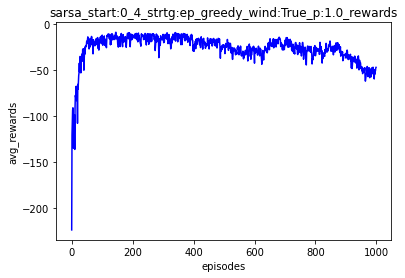

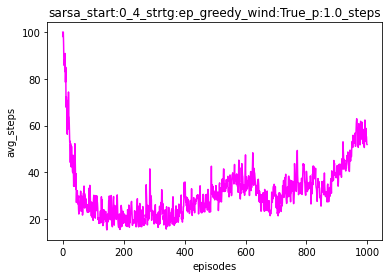

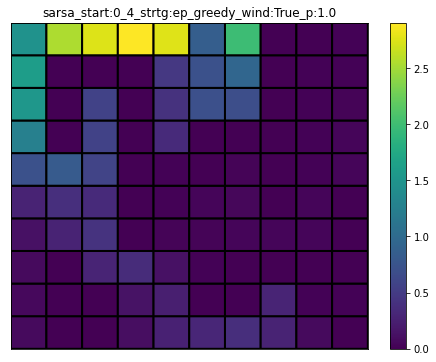

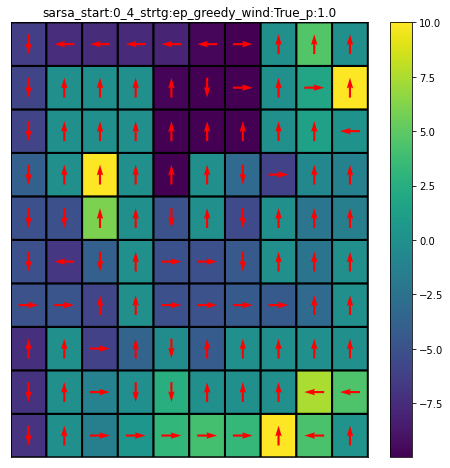

In [ ]:
# Plot Configuration: 

np.random.seed(3)

algo = "sarsa"        # either "sarsa" or "qlearning"
strtg = "ep_greedy"   # either "ep_greedy" or "softmax"
start = "0_4"         # either "0_4" or "3_6"
wind = True           # either True or False
p = 1.0               # either 1.0 or 0.7

strtg_param = 0.01    # strtg_param can be "epsilon" value for ep_greedy or "beta" value for softmax
gamma = 0.9
lr = 1.0

start_state = np.array([[int(x) for x in start.split("_")]])

env = get_environment(start_state, wind, p)
ex_strtg = EXPLORATION_STATEGY_MAP[strtg](strtg_param)
algo_obj = LEARNING_ALGO_MAP[algo](env, ex_strtg, lr, gamma)
avg_rwd, avg_steps, avg_Q, avg_state_visit_cnt = algo_obj.avg_performance(num_epochs=NUM_EPOCHS, num_episodes=NUM_EPISODES)
episodes = np.arange(NUM_EPISODES)

message = f"{algo}_start:{start}_strtg:{strtg}_wind:{wind}_p:{p}"

print(f"rwd:{avg_rwd[-1]} steps:{avg_steps[-1]}\n")

rewards_steps_plots(avg_rwd, avg_steps, episodes, message)
plot_step(avg_state_visit_cnt, message)
plot_Q(avg_Q, message)